📁 DATA_PATH: c:\Users\PC\PycharmProjects\PythonProject10\data_intelligence_system\data\processed\clean_data.csv
📁 OUTPUT_DIR: c:\Users\PC\PycharmProjects\PythonProject10\data_intelligence_system\reports\output
🎯 عمود الهدف المحدد: species
🔢 عددية: ['petal_length_cm', 'petal_width_cm', 'freshness_days']
🔤 نوعية: ['color', 'is_fragrant']
⚠️ لا بيانات كافية للارتباط: petal_length_cm
⚠️ لا بيانات كافية للارتباط: petal_width_cm
⚠️ لا بيانات كافية للارتباط: freshness_days
--- Pearson ---
Empty DataFrame
Columns: [Pearson Corr, p-value]
Index: []
--- Spearman ---
Empty DataFrame
Columns: [Spearman Corr, p-value]
Index: []
--- Cramér's V ---
             Cramér's V
color          0.007524
is_fragrant    0.000000
--- الانحدار الخطي ---
Empty DataFrame
Columns: []
Index: []


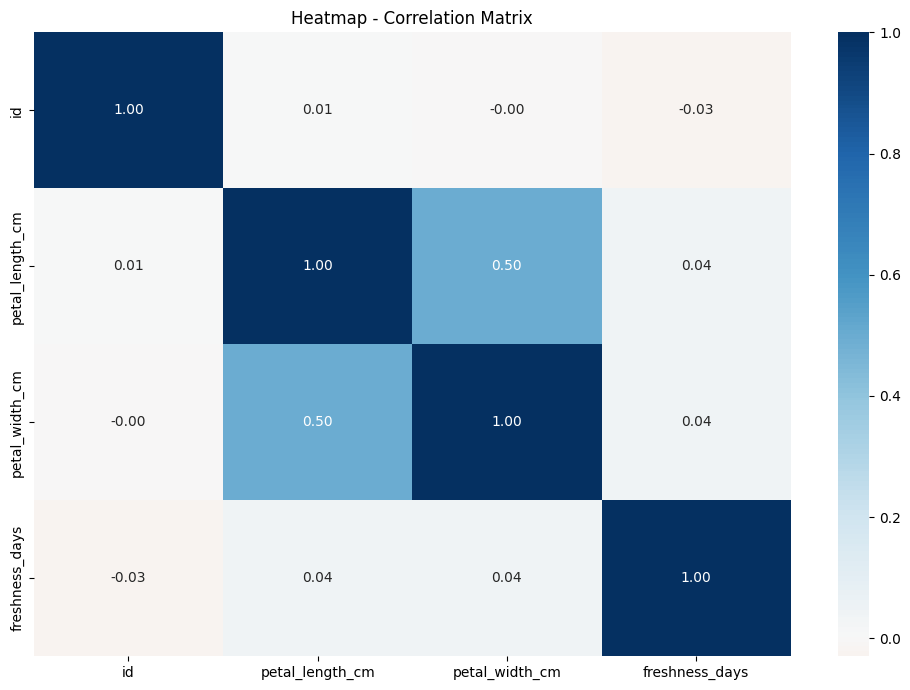

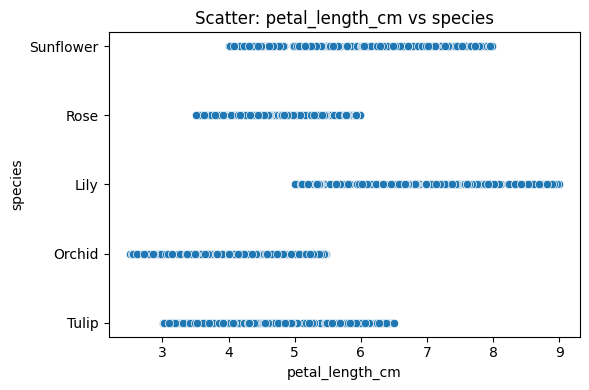

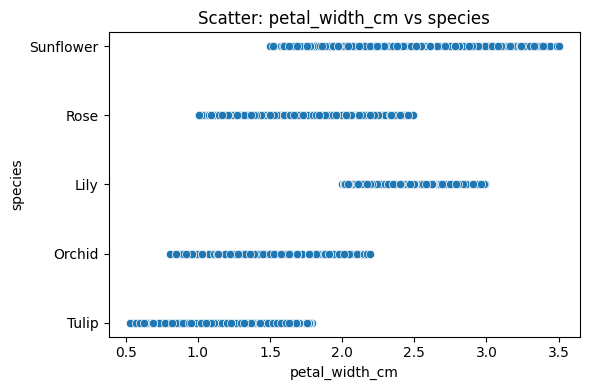

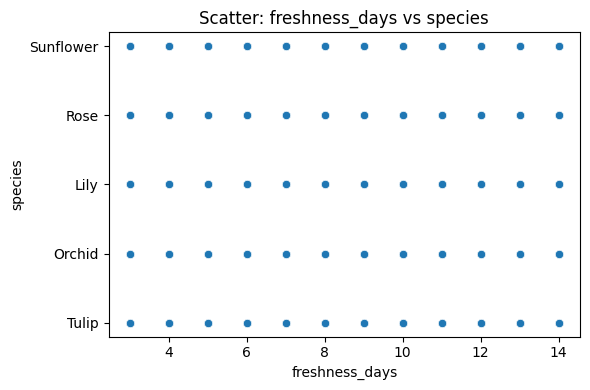

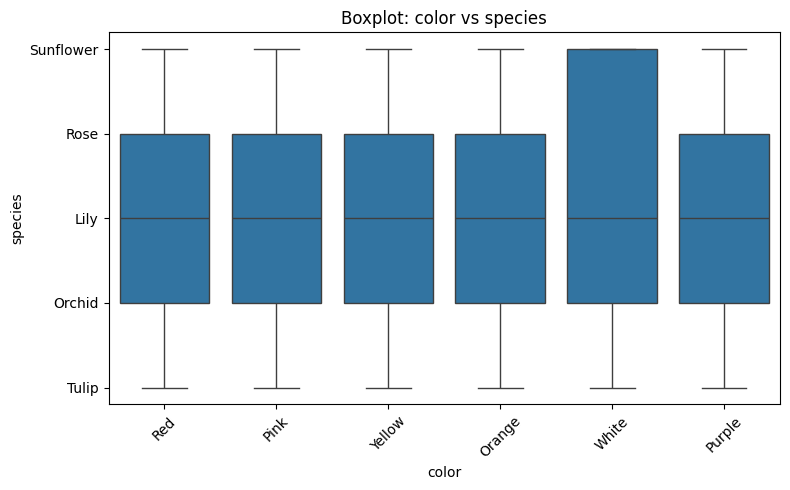

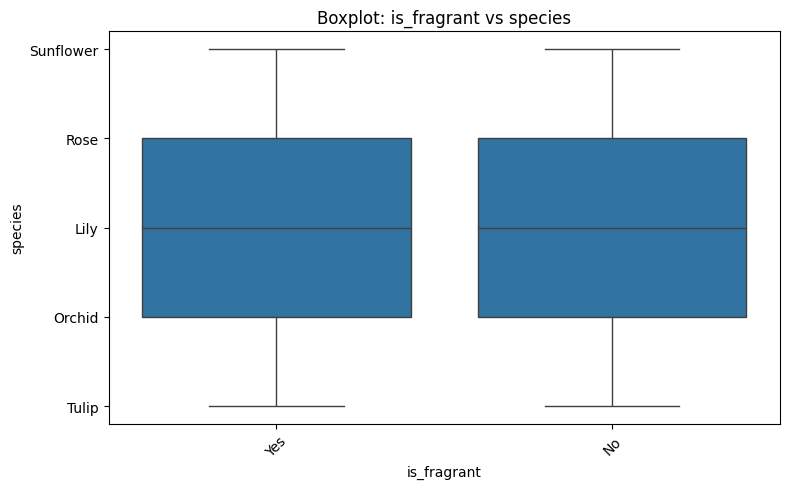

📁 تم حفظ الملخص: c:\Users\PC\PycharmProjects\PythonProject10\data_intelligence_system\reports\output\target_relationship_summary.csv


In [10]:
# 🔍 07 – تحليل العلاقة مع المتغير الهدف
"""
الهدف: فهم قوة وتأثير كل متغير مستقل على المتغير الهدف باستخدام أساليب تحليلية وإحصائية متعددة.

المخرجات:
- مقاييس ارتباط (Pearson, Spearman, Cramér's V)
- تحليلات الانحدار البسيط
- رسومات توضيحية (Scatter, Boxplot, Heatmap)
- استنتاجات واضحة وقابلة للتطبيق
- ملف CSV ملخص للنتائج التحليلية
"""

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')

# --- إعداد المسارات بشكل مرن ---
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()

PROJECT_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, '..'))
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'clean_data.csv')
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'reports', 'output')
SUMMARY_OUTPUT_PATH = os.path.join(OUTPUT_DIR, 'target_relationship_summary.csv')
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📁 DATA_PATH: {DATA_PATH}")
print(f"📁 OUTPUT_DIR: {OUTPUT_DIR}")

if not os.path.exists(DATA_PATH):
    sys.exit(f"⚠️ لم يتم العثور على ملف البيانات: {DATA_PATH}")

# --- تحميل البيانات ---
df = pd.read_csv(DATA_PATH)

# --- تحديد عمود الهدف تلقائيًا ---
target_col = None
possible_targets = ['target', 'label', 'y', 'species', 'is_fragrant']
for col in df.columns:
    if col.lower() in possible_targets:
        target_col = col
        break

if not target_col:
    print("الأعمدة الموجودة:", df.columns.tolist())
    sys.exit("⚠️ لا يوجد عمود هدف معروف")

print(f"🎯 عمود الهدف المحدد: {target_col}")

# --- فصل المتغيرات ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- حذف الصفوف الناقصة ---
if df.isnull().sum().sum() > 0:
    print("⚠️ توجد قيم ناقصة، سيتم الحذف")
    df = df.dropna(subset=[target_col] + list(X.columns))
    X = df.drop(columns=[target_col])
    y = df[target_col]

# --- تصنيف المتغيرات ---
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# استبعاد معرفات أو أعمدة غير تحليلية
ignore_cols = ['id', 'index']
numerical_cols = [col for col in numerical_cols if col.lower() not in ignore_cols]

print(f"🔢 عددية: {numerical_cols}")
print(f"🔤 نوعية: {categorical_cols}")

# === 1. معاملات الارتباط ===
corr_pearson = {}
corr_spearman = {}

for col in numerical_cols:
    try:
        x_vals = pd.to_numeric(X[col], errors='coerce')
        y_vals = pd.to_numeric(y, errors='coerce')
        valid_idx = x_vals.notnull() & y_vals.notnull()
        if valid_idx.sum() == 0:
            print(f"⚠️ لا بيانات كافية للارتباط: {col}")
            continue
        corr_pearson[col] = pearsonr(x_vals[valid_idx], y_vals[valid_idx])
        corr_spearman[col] = spearmanr(x_vals[valid_idx], y_vals[valid_idx])
    except Exception as e:
        print(f"⚠️ فشل Pearson/Spearman للعمود {col}: {e}")

pearson_df = pd.DataFrame.from_dict(corr_pearson, orient='index', columns=['Pearson Corr', 'p-value'])
spearman_df = pd.DataFrame.from_dict(corr_spearman, orient='index', columns=['Spearman Corr', 'p-value'])

print("--- Pearson ---")
print(pearson_df)
print("--- Spearman ---")
print(spearman_df)

# === 2. Cramér's V للنوعي ===
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    denom = min((kcorr - 1), (rcorr - 1))
    return np.sqrt(phi2corr / denom) if denom else np.nan

categorical_corr = {}
for col in categorical_cols:
    if df[col].nunique() > 20:
        print(f"⚠️ العمود '{col}' يحتوي على أكثر من 20 فئة")
    conf_mat = pd.crosstab(df[col], y)
    categorical_corr[col] = cramers_v(conf_mat)

cat_corr_df = pd.DataFrame.from_dict(categorical_corr, orient='index', columns=["Cramér's V"])
print("--- Cramér's V ---")
print(cat_corr_df)

# === 3. تحليل انحدار بسيط ===
regression_results = {}

for col in numerical_cols:
    try:
        x_ = pd.to_numeric(X[col], errors='coerce').dropna().values.reshape(-1, 1)
        y_ = pd.to_numeric(y, errors='coerce').dropna().values.reshape(-1, 1)
        valid_length = min(len(x_), len(y_))
        if valid_length == 0:
            continue
        lr = LinearRegression()
        lr.fit(x_[:valid_length], y_[:valid_length])
        regression_results[col] = {
            'Coefficient': lr.coef_[0][0],
            'Intercept': lr.intercept_[0],
            'R^2': lr.score(x_[:valid_length], y_[:valid_length])
        }

        # رسم الانحدار
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=x_[:valid_length].flatten(), y=y_[:valid_length].flatten(), alpha=0.6)
        plt.plot(x_[:valid_length], lr.predict(x_[:valid_length]), color='red')
        plt.title(f'Regression: {col} vs {target_col}')
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ فشل الانحدار للعمود {col}: {e}")

regression_df = pd.DataFrame(regression_results).T
print("--- الانحدار الخطي ---")
print(regression_df)

# === 4. الرسومات ===
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="RdBu", center=0)
plt.title("Heatmap - Correlation Matrix")
plt.tight_layout()
plt.show()

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=y)
    plt.title(f'Scatter: {col} vs {target_col}')
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col], y=y)
    plt.title(f'Boxplot: {col} vs {target_col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === 5. ملخص CSV ===
summary_df = pd.DataFrame(index=df.columns.drop(target_col))

for col in pearson_df.index:
    summary_df.loc[col, 'Pearson Corr'] = pearson_df.loc[col, 'Pearson Corr']
    summary_df.loc[col, 'Pearson p-value'] = pearson_df.loc[col, 'p-value']

for col in spearman_df.index:
    summary_df.loc[col, 'Spearman Corr'] = spearman_df.loc[col, 'Spearman Corr']
    summary_df.loc[col, 'Spearman p-value'] = spearman_df.loc[col, 'p-value']

for col in cat_corr_df.index:
    summary_df.loc[col, "Cramér's V"] = cat_corr_df.loc[col, "Cramér's V"]

for col in regression_df.index:
    summary_df.loc[col, 'Regression Coef'] = regression_df.loc[col, 'Coefficient']
    summary_df.loc[col, 'Regression Intercept'] = regression_df.loc[col, 'Intercept']
    summary_df.loc[col, 'Regression R^2'] = regression_df.loc[col, 'R^2']

summary_df.to_csv(SUMMARY_OUTPUT_PATH)
print(f"📁 تم حفظ الملخص: {SUMMARY_OUTPUT_PATH}")

if __name__ == "__main__":
    pass
